# SANSA AWS Informal Settlements in South Africa:

Use high resolution satellite imagery from urban South Africa to identify the locations of informal settlements

In [1]:
#!pip install -q efficientnet

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss
import os
import shutil

import tensorflow as tf
import efficientnet.tfkeras as efn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
# Data loading
image_dir = "./images/"
train_dir = "./Train.csv"
sub_dir = "./SampleSubmission.csv"

sub = pd.read_csv(sub_dir)
train_data = pd.read_csv(train_dir)

In [11]:
# Global variables
FAST_RUN = False
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
# Set seed for reproducibility
tf.random.set_seed(42)

In [4]:
train_filenames = os.listdir('./images/train/train_images/')
image_df = pd.DataFrame({
    'ID': [train_filenames[i].strip('.jpg') for i,_ in enumerate(train_filenames)],
    'image': train_filenames
})

In [5]:
train_data = train_data.merge(image_df, how='left', on='ID')

In [6]:
train_data.head()

,ID,LAT,LON,Label,image
0,0059CI9,-25.723,28.392,False,0059CI9.jpg
1,007HEF7,-25.691,28.448,False,007HEF7.jpg
2,00IKFRY,-25.733,28.421,True,00IKFRY.jpg
3,01FS05D,-25.771,28.379,False,01FS05D.jpg
4,01QE5P2,-25.749,28.413,False,01QE5P2.jpg


In [7]:
test_data = pd.read_csv('./Test.csv')
test_data.head(3)

,ID,LAT,LON
0,00MZGKU,-29.8920,30.8575
1,015JA41,-29.8905,30.8705
2,01POB64,-29.9615,30.8950


### Preparing the data:

* Analyse the spread of images between the classes to check whether the dataset is balanced or not.
* Split the train images further into train and validation images.
* Create train and validation image generators.
 * I'll be using tensorflow's (keras) `ImageDataGenerator()` to load the images. The Dataset API `(tf.data.Dataset())` provides another way of loading data with tensorflow.
 * Image transformation such as normalizing pixel values and augmentations such as horizontal flipping.

Text(0, 0.5, 'Number of images in train set')

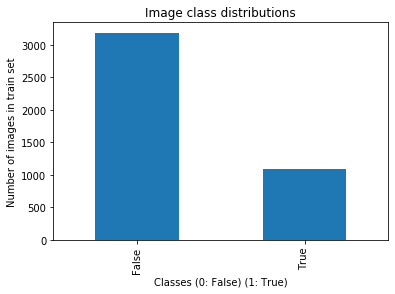

In [8]:
# Plotting the image class distributions in the train set
train_data['Label'].value_counts().plot.bar()
plt.title('Image class distributions')
plt.xlabel('Classes (0: False) (1: True)')
plt.ylabel('Number of images in train set')

In [9]:
# Further splitting the train images into train and validation images.
#train_data['Label'] = train_data['Label'].replace({0:'False', 1:'True'})
train_data['Label'] = train_data['Label'].astype(str)

In [12]:
# Defining the model
model = Sequential()
#Layer1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Layer2
model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Layer3
model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Classification layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#Output layer
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.2e-3), metrics=['accuracy'])


In [11]:
# Loading the MobileNet-V2 pre-trained model
# I'll be using it as a feature extractor here
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
                                               include_top=False,
                                               weights='imagenet')

resnet50 = tf.keras.applications.ResNet50(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
                                          include_top=False,
                                          weights='imagenet')

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


94773248/94765736 [==============================] - 1s 0us/step


In [12]:
#Freezing Model Weights (convolutional base)
#Freezing (by setting layer.trainable = False) prevents the weights of the pretrained model from being updated during training.
mobile_net.trainable = False
resnet50.trainable = False
# Visualizing base model architecture
mobile_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 201, 201, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 100, 100, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 100, 100, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [13]:
# Transfer learning

#MobileNet
mobileNet_model = Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(2, activation='softmax')
])

base_learning_rate = 0.0001

mobileNet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])


#ResNet
# Defining the model for training
resnet_model = Sequential([
    resnet50,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(2, activation='softmax')
])

base_learning_rate = 0.0001

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [16]:
# Efficient-Net
e_net = tf.keras.Sequential([
            efn.EfficientNetB3(
            input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
            weights='imagenet',
            include_top=False
        ),
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])
        
e_net.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy']
              )
    
    
e_net.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 16, 16, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1537      
Total params: 10,785,065
Trainable params: 10,697,769
Non-trainable params: 87,296
_________________________________________________________________


In [17]:
earlystop = EarlyStopping(patience=3) # Stop if validation loss doesn't improve after 5 epochs

# Gradually reduce the learning rate if validation loss doesn't improve after 5 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='lr', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.25, 
                                            min_lr=0.00001
                                           )

callbacks = [learning_rate_reduction]

In [19]:
# Training loop
splits = 5
kfold = StratifiedKFold(n_splits=splits, shuffle=False)
for i, (train_index, val_index) in enumerate(kfold.split(train_data, train_data['Label'])):
    tr_data = train_data.loc[train_index]
    val_data = train_data.loc[val_index]
    
    tr_data = tr_data.reset_index(drop=True)
    val_data = val_data.reset_index(drop=True)
    
    total_train = tr_data.shape[0]  #total train images
    total_validate = val_data.shape[0] #total images on validation set
    batch_size = 8
    
    # Train generator
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1
    )

    train_generator = train_datagen.flow_from_dataframe(
        tr_data, 
        './images/train/train_images/', 
        x_col = 'image',
        y_col = 'Label',
        target_size = IMAGE_SIZE,
        class_mode = 'categorical',
        batch_size = batch_size,
    )

    # Validation generator
    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_dataframe(
        val_data, 
        './images/train/train_images/', 
        x_col='image',
        y_col='Label',
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        batch_size=batch_size,
    )

    tf.keras.backend.clear_session()
    # Model training
    epochs = 3 if FAST_RUN else 8
    
    hist = e_net.fit(
        train_generator, 
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = int(90/batch_size),
        steps_per_epoch = int(90/batch_size),
        callbacks = callbacks
    )

Found 3424 validated image filenames belonging to 2 classes.
Found 857 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 11 steps
Epoch 1/8
11/11 [==============================] - 23s 2s/step - loss: 0.7286 - accuracy: 0.5000 - val_loss: 0.8464 - val_accuracy: 0.5000
Epoch 2/8
11/11 [==============================] - 18s 2s/step - loss: 0.7167 - accuracy: 0.5000 - val_loss: 0.7820 - val_accuracy: 0.5000
Epoch 3/8
11/11 [==============================] - 18s 2s/step - loss: 0.6989 - accuracy: 0.5000 - val_loss: 0.7582 - val_accuracy: 0.5000
Epoch 4/8
10/11 [==========================>...] - ETA: 1s - loss: 0.6956 - accuracy: 0.5000
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
11/11 [==============================] - 19s 2s/step - loss: 0.6955 - accuracy: 0.5000 - val_loss: 0.7233 - val_accuracy: 0.5000
Epoch 5/8
11/11 [==============================] - 18s 2s/step - los

In [16]:
# Save model weights
resnet_model.save_weights("resnet50.h5")
#model.save_weights("ConvNet.h5")

In [20]:
test_filenames = os.listdir('./images/test/test_images/')
test_df = pd.DataFrame({
    'ID': [test_filenames[i].strip('.jpg') for i,_ in enumerate(test_filenames)],
    'image': test_filenames
})
nb_samples = test_df.shape[0]
nb_samples

2613

In [21]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    './images/test/test_images/', 
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

predictions = e_net.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

Found 2613 validated image filenames.


In [22]:
test_df['Label'] = predictions#.max(1)
sub = test_df.copy().drop('image', axis=1)
sub.head()

,ID,Label
0,00MZGKU,0.491683
1,015JA41,0.485741
2,01POB64,0.489499
3,02125F8,0.480872
4,03E8VFF,0.493145


In [24]:
#os.mkdir('./submissions')
sub.to_csv('./submissions/sub_e-net.csv', index=False)

In [23]:
min(sub['Label'])

0.4662356972694397

### Training:
Approach-1 (Build ConvNet from scratch)

Task-bag:
* Define the Model and its attributes `(Model Architecture)`
    * I'll make use of the `Sequential()` api defined in `tf.keras.models`
* Compile the model
    * Since there are 2 classes of images in the dataset, I'll set `loss=binary_crossentropy`.
* Define training parameters and optimizations
    * EarlyStopping
    * learning rate decay.


In [ ]:
# Training the model
epochs = 10 if FAST_RUN else 20 #200
history = model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = 70, #total_validate//batch_size,
    steps_per_epoch = 70, #total_train//batch_size,
    callbacks = callbacks
)

Epoch 1/100
52/70 [=====================>........] - ETA: 53s - loss: 1.2875 - accuracy: 0.5769

In [ ]:
model.save_weights("model.h5")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [22]:
epochs = 10 if FAST_RUN else 15
hist = mobileNet_model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = 70,
    steps_per_epoch = 70,
    callbacks = callbacks
)

Epoch 1/15
70/70 [==============================] - 183s 3s/step - loss: 0.6387 - accuracy: 0.6580 - val_loss: 0.6429 - val_accuracy: 0.6911
Epoch 2/15
70/70 [==============================] - 151s 2s/step - loss: 0.5506 - accuracy: 0.7437 - val_loss: 0.6115 - val_accuracy: 0.7071
Epoch 3/15
70/70 [==============================] - 140s 2s/step - loss: 0.4695 - accuracy: 0.7911 - val_loss: 0.6022 - val_accuracy: 0.7188
Epoch 4/15
70/70 [==============================] - 144s 2s/step - loss: 0.4856 - accuracy: 0.7723 - val_loss: 0.5659 - val_accuracy: 0.7214
Epoch 5/15
70/70 [==============================] - 142s 2s/step - loss: 0.4693 - accuracy: 0.7732 - val_loss: 0.5431 - val_accuracy: 0.7330
Epoch 6/15
70/70 [==============================] - 138s 2s/step - loss: 0.4626 - accuracy: 0.7866 - val_loss: 0.5275 - val_accuracy: 0.7411
Epoch 7/15
70/70 [==============================] - 139s 2s/step - loss: 0.4433 - accuracy: 0.7893 - val_loss: 0.5071 - val_accuracy: 0.7527
Epoch 8/15
70

In [23]:
# Save model weights
mobileNet_model.save_weights("mobilenet.h5")

### Predicting on the test set

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max